In [1]:
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(effects))
suppressPackageStartupMessages(library(nlme))

# Generalised Least Squares
We will start our journey into the world of mixed-effects models by first examining a *related* approach that we have seen before: Generalised Least Squares (GLS). The reason for doing this is twofold. Firstly, GLS actually provides a simpler solution to many of the issues with the repeated measures ANOVA and thus presents a more logical starting point. Secondly, limitations in the way that GLS does this will provide some motivation for mixed-effects as a more complex, but ultimately more flexible, method of dealing with this problem.

## GLS Theory
We previously came across GLS in the context of allowing different variances for different groups of data in ANOVA-type models. This was motivated as a way of lifting the assumption of *homogeneity of variance*. However, GLS is actually a much more general technique. To see this, note that the probability model for GLS is

$$
\mathbf{y} \sim \mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}\right),
$$

where $\boldsymbol{\Sigma}$ can take on *any structure*. In other words, GLS has exactly the same probability model as the normal linear model, except that it allows for a flexible specification of the variance-covariance matrix. In our previous examples, we used GLS to populate the variance-covariance matrix with different variances for each group. For instance, if we had two groups with three subjects each, our GLS model would be

$$
\begin{bmatrix}
y_{11} \\
y_{21} \\
y_{31} \\
y_{12} \\
y_{22} \\
y_{32} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
\mu_{1} \\
\mu_{1} \\
\mu_{1} \\
\mu_{2} \\
\mu_{2} \\
\mu_{2} \\
\end{bmatrix},
\begin{bmatrix}
\sigma^{2}_{1}  & 0              & 0              & 0              & 0              & 0              \\
0               & \sigma^{2}_{1} & 0              & 0              & 0              & 0              \\
0               & 0              & \sigma^{2}_{1} & 0              & 0              & 0              \\
0               & 0              & 0              & \sigma^{2}_{2} & 0              & 0              \\
0               & 0              & 0              & 0              & \sigma^{2}_{2} & 0              \\
0               & 0              & 0              & 0              & 0              & \sigma^{2}_{2} \\
\end{bmatrix}
\right).
$$

This was actually a special case of GLS known as *weighted least squares* (WLS)[^weights-foot], where all the off-diagonal elements of $\boldsymbol{\Sigma}$ are 0. However, the crucial point is that  we can use GLS to impose differences in *both* the variances *and* the covariances. So while we did not do this previously, we can include *correlation* in the GLS model. Thus, if our general problem with repeated measures is that the variance-covariance structure is not correctly handled by the normal linear model, GLS provides a direct solution. Furthermore, if a core complaint of the repeated measures ANOVA is that the assumed covariance structure is too restrictive, GLS again provides a direct solution. So, on the face of it, GLS directly solves many of the issues we encountered last week.

### What Does GLS Do?
Technically, the machinery behind GLS is based on assuming we know $\boldsymbol{\Sigma}$ *a priori*. Although this would seem a silly place to start (given that we will almost *never* know this), we can go along with it and see where it gets us. So, *if* we know what the true covariance structure is, GLS provides a way of *removing* it from the data[^white-foot]. Once removed, the errors return to $i.i.d.$ and we are back in the world of the normal linear model. This is a very enticing prospect because all the difficulties associated with correlation effectively *disappear* and we can treat the data as a regular collection of independent values. So, although this *removal* procedure happens behind the scenes, we can conceptualise GLS as effectively a *transformation* that treats the covariance structure as *nuisance* and removes it, allowing all the theory from last semester to still apply.

In terms of the real world, if we do not known $\boldsymbol{\Sigma}$ then we cannot technically use GLS. This would seem a bit of a dead-end. However, it is possible to use a method such as REML to *estimate* $\boldsymbol{\Sigma}$ from the data. This is known as *feasible generalised least squares* (FGLS). The question then becomes, how does working with $\hat{\boldsymbol{\Sigma}}$ rather than $\boldsymbol{\Sigma}$ change things? This is a much bigger question that goes *beyond* FGLS and extends to *any* methods where the covariance structure is *estimated*, mixed-effects included.

## Estimating the Covariance Structure
If we *do not* know $\boldsymbol{\Sigma}$ ahead of time, then the term $\boldsymbol{\Sigma}$ is no longer a *fixed constant*. Instead, we have $\hat{\boldsymbol{\Sigma}}$, which is a *random variable*. This introduces an additional layer of uncertainty that causes some major issues. The full story is given in the drop-down below, but the short version is that treating $\hat{\boldsymbol{\Sigma}}$ as an *estimate* means we no longer know what null distribution our test statistic has. In fact, the whole concept of degrees of freedom as a metric that captures this uncertainty suddenly disappear. This means we do not know how the standard errors are distributed, do not know how our test statistic is distributed and have no way of calculating a $p$-value. In short, *our inferential machinery falls apart*.

`````{admonition} How Estimating $\boldsymbol{\Sigma}$ Breaks Inference
:class: tip, dropdown

To understand why the NHST machinery breaks, we need to go back to some of the information covered last semester on [statistical inference](https://pchn63101-advanced-data-skills.github.io/Inference-Linear-Model/2.estimation-uncertainty.html). Recall that in the normal linear model the uncertainty that comes from estimating $\sigma^{2}$ affects inference via the *denominator* of the test statistic. If we *know* $\sigma^{2}$, then our test statistic is a $z$-statistic and is distributed as $z \sim \mathcal{N}(0,1)$. However, when $\sigma^{2}$ is *estimated*, the test statistic is a $t$-statistic and is distributed as $t \sim \mathcal{T}(\nu)$. Here, $\nu$ is the *degrees of freedom*, which characterises the *uncertainty* in the estimate of $\sigma^{2}$. This is what controls the *width* of the $t$-distribution, which will approach the standard normal as the sample size increases. In other words, we can think of the degrees of freedom as "the amount to which the null distribution deviates from a standard normal due to uncertainty in the estimation of $\sigma^{2}$". So the degrees of freedom are *key*.

Now, the whole reason the $t$-distribution exists is because it can be derived from the structure of the test statistic. Because both the numerator and denominator are *estimates*, they are both random variables with a given sampling distribution. In order to work out the distribution of their ratio, *both* sampling distributions need to be derived. Last semester, we showed that the distribution of the parameter estimates was a known quantity. For a single slope from a typical regression model, we have

$$
\hat{\beta}_{1} \sim \mathcal{N}\left(\beta_{1}, \frac{\sigma^{2}}{\sum{(x_{i} - \bar{x})^{2}}}\right).
$$

Importantly, the variance of this distribution depends upon knowing $\sigma^{2}$, which we do not. If we replace this with an *estimate*, $\hat{\sigma}^{2}$, we introduce another layer of uncertainty. In order to characterise this addition layer, we need to know the distribution of $\hat{\sigma}^{2}$. We glossed-over this last semester, but under the normal linear model this estimate has the following sampling distribution

$$
\hat{\sigma}^{2} \sim \frac{\sigma^{2}}{\nu}\chi^{2}(\nu)
$$

This is a $\chi^{2}$ distribution with $\nu$ degrees of freedom that is scaled into the same units as the variance. The thing to notice here is that this distribution is *where degrees of freedom come from*. The reason degrees of freedom exist is because they appear as a parameter that governs the *width* of this sampling distribution. Thus, degrees of freedom directly encode uncertainty around the true value of $\sigma^{2}$. As the sample size goes up, the degrees of freedom go up and the $\chi^{2}$ gets *narrower* until it collapses into a single point centred on $\sigma^{2}$. Because the standard error of the parameter estimate depends upon the estimate of $\sigma^{2}$, the scaled $\chi^{2}$ distribution passes this uncertainty on to the $t$-distribution. As such, the $t$-distribution is similarly parameterised by the degrees of freedom. The point where the $\chi^{2}$ collapses to a single point is *exactly* when the $t$-distribution and the standard normal become *the same*. At that point, uncertainty is effectively 0 and the degrees of freedom are no longer important. 

Now, getting back to FGLS, what happens to the standard error when $\sigma^{2}$ is no longer *a single number* and is instead a complex function of different elements of an unstructured variance-covariance matrix? Well, the formula for the standard error remains *correct*, but the distribution can no longer be derived analytically. It ceases to be a consistent object across all models and, in effect, becomes *unknowable*. This means that the scaled $\chi^{2}$ distribution disappears and, along with it, so too does the concept of degrees of freedom as a means of characterising uncertainty. If we divide our parameter estimate by its standard error it is no longer the ratio of two random variables with known distributions. It is the ratio of a random variable with a known distribution and a random variable *with no known distribution*. This makes the null distribution of this test statistic *also unknown*. And without a known null, there is no way to calculate a $p$-value. So, if we accept that $\hat{\boldsymbol{\Sigma}}$ is an *estimate* then our test statistic has no known null distribution, our ability to calculate $p$-values disappears and the concept of degrees of freedom vanishes. In short, we are stuck.
`````

There are generally 3 ways to deal with this situation and we will see that different packages have differing opinions on the best way to go about it. This is true both for FGLS and for mixed-effects models

### 1. Ignore the Problem
Our first option is to *ignore* the problem. If we treat our estimate as *exactly* the population value, then we can carry on without any issues. So, if we take $\hat{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}$ then there are no problems any more. In the context of GLS, this means we can remove the covariance structure *perfectly* and the whole problem reduces back to a regular regression model with $i.i.d.$ errors. So, we simply act as if we knew $\boldsymbol{\Sigma}$ all along.

Although this is *practically* appealing, because all the mess indicated above disappears, it comes with some consequences:

- The extra uncertainty from estimating $\boldsymbol{\Sigma}$ is simply ignored. This means the model contains no penalty for estimating all the variance and covariance parameters.
- This means that standard errors may be too small, test statistics too large and $p$-values overly-optimistic, especially in small samples.
- We are pretending that degrees of freedom exist, but they technically do not.

As we will see, this what the `gls()` function choses to do by default.

### 2. Calculate *Effective* Degrees of Freedom
Our second option is to accept that $\hat{\boldsymbol{\Sigma}}$ is an estimate and accept that we need to accommodate this uncertainty somehow. In order to do this, we can create *fictitious* degrees of freedom to allow a $p$-value to be calculated. So, although we fully accept that degrees of freedom no longer exist, what we can do is *find* a null distribution that matches our model and then use the degrees of freedom from that distribution as our metric of uncertainty. For instance, we can use information in the model to approximate the *variance* of the calculated test statistic. If we know that the variance of the $t$-distribution is $\frac{\nu}{\nu - 2}$, then we can use our approximated variance to solve for $\nu$. This gives us a $t$-distribution with the *correct width* for our calculated test statistic. These fictitious degrees of freedom are known as *effective* degrees of freedom and allow a $p$-value to be calculated.

This method is perhaps more appealing than simply pretending there is no problem, though it also comes with some consequences:

- We are assuming that the true null distribution only differs from known null distributions (such as the $t$ and $F$) by its width, but not the general shape.
- This still remains an *approximation*, though it should behave better in smaller samples when degrees of freedom become more necessary.
- Degrees of freedom can become fractional and no longer have a clear theoretical grounding. They are more devices to encode "tail-heaviness" within a familiar language of $t$ and $F$ distributions. 

As we will see, this is what some methods associated with FGLS models use and is often the solution employed in mixed-effects models.

### 3. Produce Results that are *Asymptotically* Correct
Finally, our third option is to side-step all the messiness with degrees of freedom entirely. Recall from the normal linear model that the uncertainty that comes from estimating $\sigma^{2}$ effectively *disappears* once the same size is large enough. This is because $\hat{\sigma}^{2} = \sigma^{2}$, for all practical purposes. Thus, we can treat everything as if $\sigma^{2}$ is known, because our uncertainty is effectively 0. We saw this in the shape of the $t$-distribution. Once the sample size is big enough, the $t$-distribution *becomes* a standard normal distribution whose width is fixed, rather than adaptive. When this happens, the degrees of freedom disappear. So, whilst we normally work with something like

$$
\frac{\hat{\beta}_{1}}{\text{SE}(\hat{\beta}_{1})} \sim \mathcal{T}(\nu),
$$

it is not wrong to work with

$$
\frac{\hat{\beta}_{1}}{\text{SE}(\hat{\beta}_{1})} \sim \mathcal{N}(0,1).
$$

The only caveat is that the sample size needs to be *big enough* for the second option to be accurate. However, notice that this second option *does not need degrees of freedom*. We say that this test is *asymptotically correct*, meaning it gets more accurate as $n \rightarrow \infty$. All we need to do is make the assumption that we have enough data so that we can effectively treat our estimate of $\sigma^{2}$ as the *true value*. At that point it becomes a *constant*. So, there is no uncertainty to deal with, no sampling distribution to know, no concept of degrees of freedom and all the messiness disappears.

Although this is not necessary with the normal linear model, once we are in the realm of estimating a complex covariance structure this approach becomes more appealing. There is a *statistical purity* to this result because we do not need to pretend degrees of freedom still exist nor invent fictitious degrees of freedom based on the model. However, there are some clear issues here

- We need to be comfortable assuming that our $n$ is *large-enough* for this to work, but this is an *unanswerable* question (see box below).
- We need to be comfortable with the idea of dismissing uncertainty in the estimation of $\boldsymbol{\Sigma}$ as negligible.
- Any sense of "exactness" is gone.
- In small samples, this will result in inference that is *optimistic* (though we can at least be open about this)

As we will see, this is also what some methods associated with FGLS and mixed-effects models use.

`````{admonition} How Large is "Large"?
:class: tip
If we want to lean on asymptotic theory and pretend that everything is fine when using FGLS, the obvious question is "how big does $n$ need to be?". The problem is that the definition is based on a *limit*, so it says that the approximation gets better and better as $n$ moves towards infinity. For our purpose, $n$ is the *number of subjects*, rather than the total amount of data. So, the answer is not that there is some magic sample size that is suddenly large enough, the answer is that the approximation will get better the larger $n$ becomes. The question then is more about what our tolerance for error is. The point of the asymptotic theory is to say that the error that comes from estimation becomes more negligible as $n$ grows, as does the penalty for estimating $\boldsymbol{\Sigma}$ from the data. So, unfortunately, there is *no honest numeric answer to this question*. The way to think about it is as a *degree of comfort*. If you are using FGLS with $n = 5$, you should feel *very uncomfortable*. If you are using $n = 50$, you should probably feel *cautious* and if you have $n > 200$ you should probably be feeling *reasonably comfortable*. As $n$ increases beyond that, you should probable feel perfectly fine about the FGLS assumptions. These are only ballpark figures, but the point is really to think of $n$ as a *continuum of comfort*, rather than as a *threshold*. 
`````

### Covariance Constraints
As well as understanding that the very process of estimating $\boldsymbol{\Sigma}$ causes problems, we also need to understand that we cannot have free reign to estimate any old covariance structure we like. One of the most important elements to recognise is that some sort of *constraint* is always needed when estimating a variance-covariance matrix. To see this, note that for a repeated measures experiment there are $nt \times nt$ values in this matrix. The values above and below the diagonal are a mirror image, so the true number of unknown values is $\frac{nt(nt + 1)}{2}$. For instance, if we had $n = 5$ subjects and $t = 3$ repeated measures, there would be $\frac{15 \times 16}{2} = 120$ unique values in the variance-covariance matrix. If we allowed it to be completely unstructured, we would have 120 values to estimate *just* for the covariance structure. Indeed, this is not really possible unless the amount of data we have *exceeds* the number of parameters. So, the data itself imposes a *constraint* on how unstructured the covariance matrix can be.

Luckily, for most applications, we not only assume that $\boldsymbol{\Sigma}$ has a block-diagonal structure (so most off-diagonal entries are 0), but that many of the off-diagonal elements are actually *identical*. We saw this previously with the repeated measures ANOVA. Even though $\boldsymbol{\Sigma}$ may have *hundreds* of values we *could* fill-in, if we assume compound symmetry only within each subject, there are only *two* covariance parameters to be estimated: $\sigma^{2}_{b}$ and $\sigma^{2}_{w}$. The whole matrix can then be constructed using those two alone. This is an example of *extreme simplification*, but it does highlight that we generally do not estimate the *whole* variance-covariance matrix. We only estimate *small parts* of it. Indeed, making the covariance matrix more general is often a risky move because of the number of additional parameters needed. The more we estimate from the same data, the greater our uncertainty will become because each element of the covariance-matrix is supported by *less data*. Complexity always comes at a price.

## GLS in `R`
We have seen some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of correlation and heterogenous variance groups. 

### The Paired $t$-test Using GLS
We can start with the most simple example of the paired $t$-test using GLS. Importantly, this is an unnecessary step theoretically because the paired $t$-test is a perfectly acceptable technique. When there are only two-repeats there are no arguments about the covariance structure. There can only be a single correlation term. So compound symmetry always works. However, it is useful for us as a *starting point* because it is the simplest example of the problem.

In order to specify a correlation structure, we need to pass one of the predefined correlation functions as an argument to `correlation=`. These structures include functions such as `corCompSymm()`, `corSpher()`, `corAR1()` and `corSymm()`[^corfunc-foot]. For this example, we will use `corCompSymm()`, which constructs a compound symmetric structure.

In order to use `corCompSymm()`, we need to supply it with a description of how we want it structured in relation to our data. This is done using the `form=` argument, which takes a one-sided formula expressing the structure we want. For this example, we will use `corCompSymm(form= ~1|subject)`. This indicates that we want a constant correlation (`1`) grouped by subject (`|subject`). So, the term on the *right* of `|` is key here. This gives a *grouping factor* such that any observations from the same level will share a constant correlation. Because we have used `subject`, each level represents a *different* subject and thus any observations that come from the same subject will be correlated. This therefore defines our *block-diagonal* covariance structure, where the term on the right of `|` forms the *blocks*. We will see ways to visualise this in order to provide more intuition a little later.

Returning to our example, we will use the `mice2` data from `datarium` again, which we have converted to long-format as discussed last week.

In [2]:
library('datarium')
library('reshape2')
data('mice2')

# repeats and number of subjects
t <- 2
n <- dim(mice2)[1]

# reshape wide -> long
mice2.long <- melt(mice2,                       # wide data frame
                   id.vars='id',                # what stays fixed?
                   variable.name="time",        # name for the new predictor
                   value.name="weight")         # name for the new outcome

mice2.long <- mice2.long[order(mice2.long$id),] # order by ID
rownames(mice2.long) <- seq(1,n*t)              # fix row names
mice2.long$id <- as.factor(mice2.long$id)

print(mice2.long)

   id   time weight
1   1 before  187.2
2   1  after  429.5
3   2 before  194.2
4   2  after  404.4
5   3 before  231.7
6   3  after  405.6
7   4 before  200.5
8   4  after  397.2
9   5 before  201.7
10  5  after  377.9
11  6 before  235.0
12  6  after  445.8
13  7 before  208.7
14  7  after  408.4
15  8 before  172.4
16  8  after  337.0
17  9 before  184.6
18  9  after  414.3
19 10 before  189.6
20 10  after  380.3


To fit this model using GLS, we use

In [3]:
library(nlme)

gls.mod <- gls(weight ~ time, correlation=corCompSymm(form=~1|id), data=mice2.long)

where we can see the use of the `correlation=` argument with the `corCompSymm()` function. We could also optionally include a `weights=` argument if we wanted the diagonal elements of the covariance matrix to differ by `time`. This would take the form `weights=varIdent(form= ~1|time)`. However, we will keep this simple for now.

### Inference Using GLS
Although we should check the assumptions of the GLS model, we will leave that to one side given that we covered it last semester. The more pressing issue for us is to discuss *inference* using the GLS model, especially given the problems highlighted earlier. To begin with, we can treat the returned objects from `gls()` just like an object from `lm()` and call `summary()` to examine the model estimates and tests.

In [4]:
print(summary(gls.mod))

Generalized least squares fit by REML
  Model: weight ~ time 
  Data: mice2.long 
      AIC      BIC    logLik
  177.349 180.9105 -84.67449

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
      Rho 
0.5332493 

Coefficients:
             Value Std.Error  t-value p-value
(Intercept) 200.56  8.081914 24.81591       0
timeafter   199.48  7.808574 25.54628       0

 Correlation: 
          (Intr)
timeafter -0.483

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.46661859 -0.54818094  0.02112903  0.38482224  1.79048964 

Residual standard error: 25.55725 
Degrees of freedom: 20 total; 18 residual


We can see here all the usual output that matches what `lm()` gives us. Indeed, despite what we mentioned earlier, we still get $t$-statistics and $p$-values (though note that the $p$-values are *rounded* rather than displayed using scientific notation). We also have information on the estimated correlation structure, with the single correlation parameter given by $\hat{\rho} = 0.53$. Of most importance is that both the *standard error* and *$t$-value* match what we saw last week from the paired $t$-test. This is evidence enough to show that the correlation *is* being taken into account. Importantly, this is being done within a linear model framework, but *without* the need to subtract the differences *or* to manually partition the errors by including `id` in the model formula.

#### The $p$-value Problem
Although all the elements highlighted above are positives, there is something important we need to recognise about the reported $p$-values. As mentioned earlier, if we work with the idea that $\boldsymbol{\Sigma}$ is *estimated* then the null distribution of the test statistics become unknown and there is no way to calculate a $p$-value. And yet, the `gls()` function *does* produce $p$-values. How? *Because it is acting as if $\boldsymbol{\Sigma}$ is known*. In effect, even though we are using FGLS, the `gls()` function ignores this and acts as if we are doing *proper* GLS with a known covariance structure. All the calculations of $t$-statistics, degrees of freedom and $p$-values are based on assuming that $\boldsymbol{\Sigma}$ is known and thus we can perfectly remove the covariance structure from the data and end-up back in the world of a normal linear model.

The problem with this is that the uncertainty in estimating $\boldsymbol{\Sigma}$ is not taken into account. Indeed, we have seen that there is no exact way of quantifying this uncertainty because the concept of degrees of freedom vanishes as soon as the sampling distribution becomes unknown. The `gls()` function is *pretending* that we known $\boldsymbol{\Sigma}$ and can return the model to a world where degrees of freedom exist and null distributions are known. The extent to which we can trust the $p$-values therefore depends upon the extent to which we are willing to follow along with this fiction. At best, we need to treat these values as *very rough approximations* and nothing more. This is especially true in *small samples*. As mentioned earlier, as $n$ gets larger the estimate of $\hat{\boldsymbol{\Sigma}}$ gets closer to the true value and the uncertainty largely disappears. So if our sample is *large*, we have less concern with the GLS tests. However, great caution is needed if our sample is *small*.

Part of the problem here is that FGLS knows *nothing* about the structure of the data. The very fact that we have repeated measurements from multiple subjects is somewhat lost inside of $\boldsymbol{\Sigma}$. All GLS knows is that there *is* correlation, but not *where it came from*. As we will see, mixed-effects models actively embed the structure that causes the data to be correlated. This does not magically get rid of the problem of an unknown sampling distribution under an arbitrary covariance structure, but it does allow for a better approximation of the uncertainty that comes from estimating $\boldsymbol{\Sigma}$. So, a mixed-effects model will not fix this situation, but it does give us better options beyond simply pretending that $\boldsymbol{\Sigma}$ is known. This is not the main reason for using mixed-effects over GLS, but it is an advantage.

#### Omnibus Tests and Follow-ups
Putting aside the inferential issues above, the utility of the GLS framework is that we can simply treat the model in the same way as a result from `lm()`. This means we can compute ANOVA-style tests 

In [5]:
anova(gls.mod)

Denom. DF: 18 
            numDF   F-value p-value
(Intercept)     1 1800.9410  <.0001
time            1  652.6124  <.0001

generate confidence intervals (though these should similarly be treated cautiously),

In [6]:
confint(gls.mod)

               2.5 %   97.5 %
(Intercept) 184.7197 216.4003
timeafter   184.1755 214.7845

create plots using the `effects` package

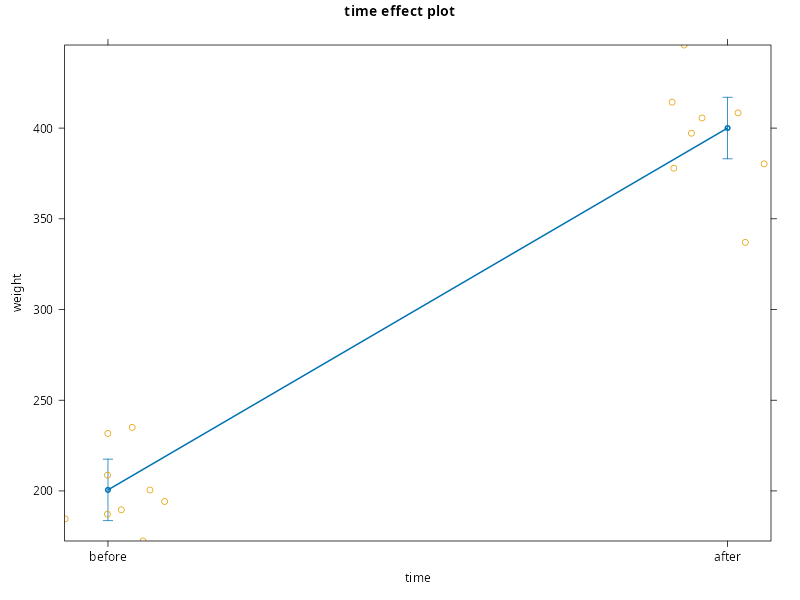

In [7]:
library('effects')
plot(effect('time', gls.mod, residuals=TRUE), partial.residuals=list(smooth=FALSE))

and compute follow-up tests using `emmeans`[^emmeans-foot]

In [8]:
library(emmeans)
emm <- emmeans(gls.mod, pairwise ~ time, mode="df.error")
print(emm$contrasts)

 contrast       estimate   SE df t.ratio p.value
 before - after     -199 7.81 17 -25.546  <.0001

Degrees-of-freedom method: df.error 


So, if we put the inferential issues to one side, we can see that GLS provides a nice alternative to the repeated measures ANOVA because it exists within the linear model framework and thus allows us to use all the methods we have seen previously. Furthermore, we can lift the assumption of compound symmetry and use a variety of different covariance matrices. The main downside is that this comes with a price in terms of the $p$-value not taking the uncertainty in the estimation of the covariance structure into account. This is especially problematic in *small samples*, which means we should really treat the hypothesis tests from a GLS model as only *asymptotically correct*. If we are happy to do so, GLS becomes quite a useful method to have on hand. We will see a few more examples of using GLS with more complex ANOVA models in the associated workshop.

## When Should We Use GLS?
GLS is most useful in situations where we know what covariance structure we want to impose on the data and are not as concerned about the model not understanding any form of deeper structure in the data. However, if we do not know the covariance structure and know that the data has a deeper structure that the model should be able to exploit, this is where mixed-effects models come into their own. 

... The problem is that GLS does not know anything about the *structure* of the data. It has no sense of *subjects* as the experimental unit, nor the idea that the outcome variable is comprised of clusters of values taken from different subjects who might themselves form clusters of values from larger groups (e.g. patients vs controls). All that GLS knows is that there is a correlation structure that we want to remove. Unfortunately, this lack of appreciation for the structure of the data means that GLS cannot use that structure to its advantage. There is no separation of the information available by pooling observations across subjects, or subjects across groups. In effect, GLS is a very *crude* solution to a bigger problem with repeated measurements. Namely, that there is a larger *hierarchical* structure at play that the model should be able to take advantage of. We have seen this in a very general way through small-sample degrees of freedom, but really this is only a *symptom* of a larger problem. As we will come to learn, mixed-effects models are advantageous precisely *because* they embed this structure in the model. This has a number of consequences, not least the fact that correlation between measurements from the same experimental unit are *automatically* embedded in the model. This is not because we tell the model to include correlation, rather it is a *natural consequence* of the structure of the data. As such, mixed-effects models are useful because features such as correlation are a natural part of the modelling framework, precisely because it does take the structure into account in a way that GLS simply cannot.

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^white-foot]: This is sometimes known as *whitening* the data. This is a term you may come across in the neuroimaging literature, particularly in relation to how fMRI is analysed.

[^emmeans-foot]: The `mode=` option has been set to `df.error` so that the reported test matches the table from `summary()`. `emmeans` actually has some better ways of adjusting the degrees of freedom to accommodate the uncertainty in estimating $\boldsymbol{\Sigma}$, but this is a complication we will leave to one side for now.